# Dynamic Causal Modelling using neurophysiological and structural connectivity data

This code implements a dynamic causal modelling analysis of effective network inference based on intracranial EEG data, using prior information from structural connectivity. Broadly the notebook will process an example dataset through the following steps:

1. Initial housekeeping (loading relevant modules, etc)
1. Loading EEG and structural connectivity data from BIDS dataset
1. Select subnetwork of interest based on communities in the covariance data
1. Perform DCM model inversion to infer synaptic parameters and effective connectivity between the nodes of the subnetwork
1. Use structural connectivity data to inform the Bayesian model inversion 

This work now allows an integration of modelling approaches currently implemented in [The Virtual Brain](https://ebrains.eu/service/the-virtual-brain/) on cloud computing platforms even in the absence of a Matlab license. 

## Housekeeping

In [1]:
# Import relevant packages
#================================================================================
import os
import sys
import time
import glob
from importlib import reload
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import mne
from mne_bids import BIDSPath, print_dir_tree
import networkx as nx
import community

import pyCM 
# import python_DCM

In [2]:
# Define local folder structure
#================================================================================
F = {}
F['base'] = '/Volumes/GoogleDrive/My Drive/Research/2201_TVP-integ'
F['bids'] = F['base'] +os.sep+ '01_Data' +os.sep+ 'bids'
F['code'] = F['base'] +os.sep+ '02_Code'
F['outp'] = F['base'] +os.sep+ '03_Output'
print_dir_tree(F['bids'])

subject     = '72'
saveoutputs = True

|bids/
|--- .DS_Store
|--- dataset_description.json
|--- participants.tsv
|--- .ipynb_checkpoints/
|--- derivatives/
|------ struct-connect/
|--------- sub-72/
|------------ connectivity/
|--------------- sub-72-dwi_conndata-network_connectivity.tsv
|--------------- sub-72-dwi_conndata-network_source_node_info.tsv
|--------------- sub-72_ses-01_task-spont_run-01_eeg.json
|--- sub-72/
|------ .DS_Store
|------ ses-01/
|--------- .DS_Store
|--------- sub-72_ses-01_scans.tsv
|--------- anat/
|------------ sub-72_ses-01_T1w.json
|------------ sub-72_ses-01_T1w.nii.gz
|--------- eeg/
|------------ sub-72_ses-01_task-spont_run-01_channels.tsv
|------------ sub-72_ses-01_task-spont_run-01_eeg.EDF
|------------ sub-72_ses-01_task-spont_run-01_eeg.json
|------------ sub-72_ses-01_task-spont_run-01_electrodes.tsv



## Loading and preprocessing data

### Load EDF files and segment to windowed interictal segments
Here we load EDF files in the BIDS dataset alongside the channel and electrode descriptors. 
The `pyCM.dataload` function here allows implementation of windowed data segmentation, which will then be saved in a matlab readable `/mat` data format

In [3]:
# Extract relevant data and descriptor files from BIDS
#----------------------------------------------------------------------------------
bids_path = BIDSPath(root=F['bids'],subject=subject,run=1,
                     datatype='eeg',session='01',task='spont')
eegpath   = str(bids_path)+'_eeg.EDF'
chans     = pd.read_csv(str(bids_path)+'_channels.tsv', sep='\t')
elect     = pd.read_csv(str(bids_path)+'_electrodes.tsv', sep='\t')

# Set up necessary folders
#----------------------------------------------------------------------------------
os.makedirs(F['outp']+os.sep+'preproc', exist_ok=True)
os.makedirs(F['outp']+os.sep+'dcm', exist_ok=True) 

# Extract epoches data from continuous recording
#----------------------------------------------------------------------------------
seeg = pyCM.dataload(eegpath, elect=elect, chans=chans, seg_type='uniform', 
                     window_secs=10, window_number=10)

if saveoutputs:
    scipy.io.savemat(F['outp']+os.sep+'preproc'+os.sep+'sub-'+subject+'_seeg_segmented.mat', 
                     {'seeg':seeg, 'subject':subject})

Extracting EDF parameters from /Volumes/GoogleDrive/My Drive/Research/2201_TVP-integ/01_Data/bids/sub-72/ses-01/eeg/sub-72_ses-01_task-spont_run-01_eeg.EDF...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Loading data for 10 events and 20481 original time points ...
0 bad epochs dropped
------------------
Data extracted 
Sampling: uniform
Epochs: 10 (10 seconds each)
Data resampled to 250Hz


### Identify representative subgroups of nodes based on membership in distinct communities 

DCM for MEG/EEG in the current implementation is limited to (full) network inference on about 10-12 nodes. In order to data from distinct subnetworks, here we implement a simple community detection algorithm from which individual nodes are drawn for subsequent DCM analysis. 
The output here will demonstrate the average covariance matrix across all samples as well as some example matrices for individual segments of the window length specified above. Example traces of a single time window of the SEEG data are then shown. 

Resolution fixed at 0.8
Consensus partition with 7 communities


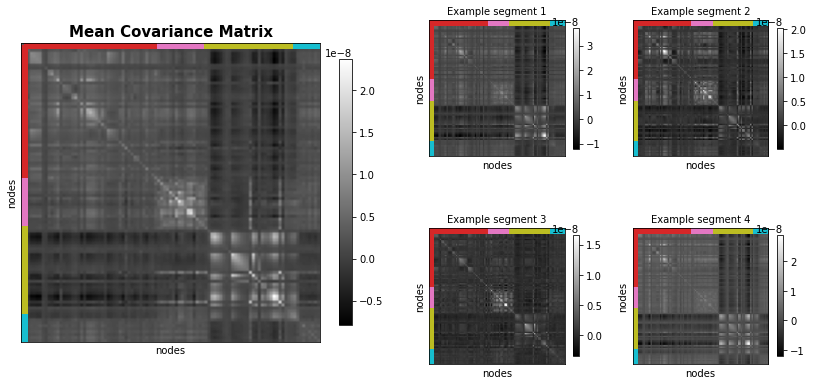

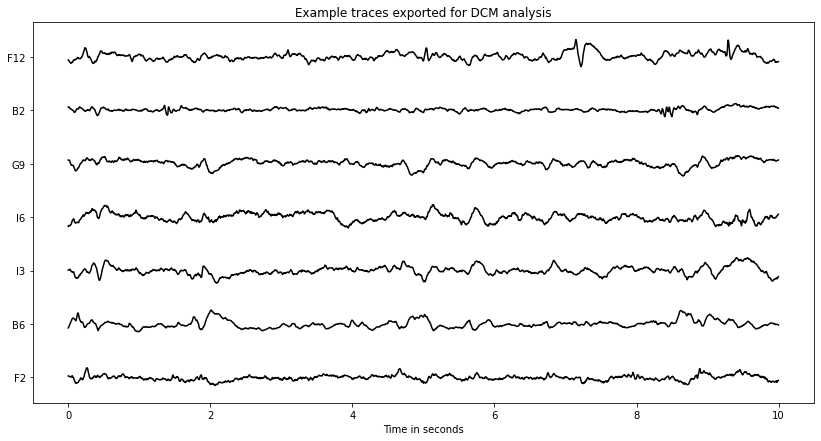

In [6]:
# Run partitioning
#----------------------------------------------------------------------------------
A, partition, nodelist = pyCM.node_selection(seeg)
scipy.io.savemat(F['outp']+os.sep+'preproc'+os.sep+'sub-'+subject+'_partition.mat', 
                 {'A':A, 'partition':partition,'nodelist':nodelist})

# Plot covariance structure in partition order
#----------------------------------------------------------------------------------
fig, ax = plt.subplot_mosaic([['m', 'm', 's1', 's2'],
                              ['m', 'm', 's3', 's4']], figsize=(14,7))
fig.patch.set_facecolor('white')
pyCM.plot_by_partition(np.mean(A, axis=0), partition, ax=ax['m'])
ax['m'].set_title('Mean Covariance Matrix', fontweight='bold', fontsize=15)
pyCM.plot_by_partition(A[0,:,:], partition, ax=ax['s1'])
ax['s1'].set_title('Example segment 1', fontsize=10)
pyCM.plot_by_partition(A[2,:,:], partition, ax=ax['s2'])
ax['s2'].set_title('Example segment 2', fontsize=10)
pyCM.plot_by_partition(A[4,:,:], partition, ax=ax['s3'])
ax['s3'].set_title('Example segment 3', fontsize=10)
pyCM.plot_by_partition(A[6,:,:], partition, ax=ax['s4'])
ax['s4'].set_title('Example segment 4', fontsize=10)

plt.show()

# Example segment plot
#-------------------------------------------------------------------------------------
segtoplot = 3
f,a = plt.subplots(1,figsize=(14,7))
for ni in range(len(nodelist)):
    a.plot(seeg['time'], seeg['data'][segtoplot,nodelist[ni],:]-ni/1000, color='k')
a.set_yticks(-np.arange(0,len(nodelist)/1000,1/1000))
a.set_yticklabels([seeg['labels'][n] for n in nodelist])
a.set_xlabel('Time in seconds')
a.set_title('Example traces exported for DCM analysis')
plt.show()

### Load structural connectivity between selected communities
As a next step we will load the structural connectivity data from the BIDS dataset, which will be used as prior information for subsequent DCM analysis and model comparison. Here we are using mock structural connectivity data for ease of sharing and demonstrating proof of prinicple. 

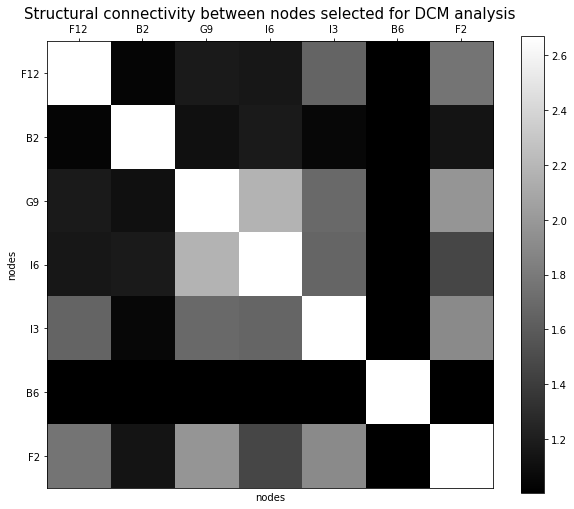

In [7]:
# Defines and loads connectivity matrix and ROI spec file from BIDS dataset
#=====================================================================================
#-------------------------------------------------------------------------------------
connct_path = F['bids']+os.sep+'derivatives'+os.sep+'struct-connect'+os.sep+'sub-'+subject+os.sep+'connectivity'
sA   = pd.read_csv(connct_path +os.sep+'sub-'+subject+'-dwi_conndata-network_connectivity.tsv', sep='\t', header=None)
sROI = pd.read_csv(connct_path +os.sep+'sub-'+subject+'-dwi_conndata-network_source_node_info.tsv', sep='\t')

roi = [label for label in sROI['name'][nodelist]]
if roi == [seeg['labels'][n] for n in nodelist]:
    sa = np.array(sA)[nodelist,:]
    sa = sa[:,nodelist]
else: warning('Region names do not match up')

f,a = plt.subplots(1, figsize=(10,12))
a.set_title('Structural connectivity between nodes selected for DCM analysis', fontsize=15)
image = a.imshow(sa, cmap='gray')
a.set_xticks(range(len(roi)))
a.set_xticklabels(roi)
a.xaxis.tick_top()
a.set_xlabel('nodes')
a.set_yticks(range(len(roi)))
a.set_yticklabels(roi)
a.set_ylabel('nodes')
plt.colorbar(image, ax=a, shrink=0.7)
plt.show()

## Setting up the file structure for DCM analysis
This sections sets up the `DCM` object that can be passed to the standalone DCM library for subsequent model inversion. We have also implemented a wrapper function that pre-specifies aspects of the analysis for the user, allowing the most common specifications to be entered directly in the function call:

`DCM      = pyCM.dcm_spec(dcm_path, labels, time, datatype='CSD', model='CMC', freq_range=[1,35])`

In [8]:
# Collate data required to make SPM readable file
#------------------------------------------------------------------------------------------
# Warning: there are some issues with scipy matload and write - adding zero dimensons
# Corrected here by hand, but worth keeping in mind for future use

# Load data and reorganise
#------------------------------------------------------------------------------------------
d        = scipy.io.loadmat(F['outp']+os.sep+'preproc'+os.sep+'sub-'+subject+'_seeg_segmented.mat')
seeg     = d['seeg']
subject  = d['subject'][0]
data     = seeg['data'][0][0]
time     = seeg['time'][0][0][0]
Fs       = seeg['Fs'][0][0][0]

p        = scipy.io.loadmat(F['outp']+os.sep+'preproc'+os.sep+'sub-'+subject+'_partition.mat')
nodelist = p['nodelist'][0]
labels   = [seeg['labels'][0][0][n] for n in nodelist] 

#===========================================================================================
# Specify DCM variable that will be used for inversion
#===========================================================================================
dcm_path = F['outp']+os.sep+'dcm'+os.sep+'DCM_sub-'+subject
DCM      = pyCM.dcm_spec(dcm_path, labels, time, datatype='CSD', model='CMC', freq_range=[1,35])

# Pack up and save
#===========================================================================================
# For this analysis, in addition to the DCM dictionary specified above, we need
#     - data  a 3D (trials x channels x time) data file
#     - time, a 1D (time) time vector (encoding time in seconds)
#     - conds, a 1D (trials) list of condition labels
#     - labels, a 1D (channels) list of channel labels
data    = data[:,nodelist,:]
time    = time
conds   = ['spontaneous' for i in range(data.shape[0])]
labels  = labels

F['spec'] = F['outp']+os.sep+'dcm'+os.sep+'sub-'+subject+'_dcm_spec.mat'
if saveoutputs:
    scipy.io.savemat(F['spec'],
                     {'data':data,'time':time,'labels':labels, 'DCM':DCM, 'conds':conds, 
                      'Fbase':F['base'], 'subject':subject})

## Run DCM Code in Standalone Matlab App
This code will require the Matlab runtime to be installed (free, without a licensing requirement) 

In [19]:
runfile     = F['code']+os.sep+'packages/pdcm/for_redistribution_files_only/run_pdcm.sh'
mlruntime   = '/Applications/MATLAB/MATLAB_Runtime/v912'

# Specify required task
#-------------------------------------------------------------------------------------------
cfg = {}
cfg['task']     = 'estimate_csd'
cfg['dcm_path'] = dcm_path
cfg['specfile'] = F['spec']
cfg_path        = F['code']+os.sep+'config.mat'
scipy.io.savemat(cfg_path, {'cfg':cfg}) 

os.system('\''+runfile+'\''+' '+'\''+mlruntime+'\''+' '+'\''+cfg_path+'\'')


------------------------------------------
Setting up environment variables
---
DYLD_LIBRARY_PATH is .:/Applications/MATLAB/MATLAB_Runtime/v912/runtime/maci64:/Applications/MATLAB/MATLAB_Runtime/v912/bin/maci64:/Applications/MATLAB/MATLAB_Runtime/v912/sys/os/maci64
SPM initialising
SPM initialised
Data type is missing or incorrect, assigning default.
SPM M/EEG data object
Type: single
Transform: time
1 conditions
7 channels
2500 samples/trial
10 trials
Sampling frequency: 250 Hz
Loaded from file  /Volumes/GoogleDrive/My Drive/Research/2201_TVP-integ/01_Data/matlab/sub-72_SEEG.mat

Use the syntax D(channels, samples, trials) to access the data
Type "methods('meeg')" for the list of methods performing other operations with the object
Type "help meeg/method_name" to get help about methods

/Volumes/GoogleDrive/My Drive/Research/2201_TVP-integ/01_Data/matlab/sub-72_SEEG

evaluating CSD for condition 1
CSD estimation complete


0

In [ ]:
# Specify required task
#-------------------------------------------------------------------------------------------
cfg = {}
cfg['task']     = 'run_dcm'
cfg['dcm_path'] = dcm_path
cfg_path        = F['code']+os.sep+'config.mat'
scipy.io.savemat(cfg_path, {'cfg':cfg, 'dcm_path':dcm_path}) 

os.system('\''+runfile+'\''+' '+'\''+mlruntime+'\''+' '+'\''+cfg_path+'\'')

------------------------------------------
Setting up environment variables
---
DYLD_LIBRARY_PATH is .:/Applications/MATLAB/MATLAB_Runtime/v912/runtime/maci64:/Applications/MATLAB/MATLAB_Runtime/v912/bin/maci64:/Applications/MATLAB/MATLAB_Runtime/v912/sys/os/maci64
SPM initialising
SPM initialised
EM:(+): 1     F: 0.000e+00 dF predicted: 6.705e+00  actual: 3.711e+00 (145.68 sec)
EM:(+): 2     F: 3.711e+00 dF predicted: 1.012e+01  actual: 5.588e+00 (192.23 sec)
EM:(+): 3     F: 9.299e+00 dF predicted: 1.605e+01  actual: 1.055e+01 (187.40 sec)
EM:(+): 4     F: 1.984e+01 dF predicted: 2.252e+01  actual: 1.422e+01 (227.64 sec)
EM:(+): 5     F: 3.407e+01 dF predicted: 1.428e+01 

## Run DCM code using the Matlab Engine
This will use an existing and licensed Matlab Environment in order to run the specified DCM analysis. Currently this does not seem to work on teb newer M1 Apple Silicon Architecture. 

### Estimate cross spectral densities from the time series data

In [48]:
import matlab.engine

# Estimate cross spectral densities and return path for DCM object
#-------------------------------------------------------------------------------------------
M        = pyCM.start_matlab(F) 
F['dcm'] = M.pdcm_estimate_csd(F['spec'], nargout=1)
M.quit()

Data type is missing or incorrect, assigning default.
SPM M/EEG data object
Type: single
Transform: time
1 conditions
10 channels
2500 samples/trial
10 trials
Sampling frequency: 250 Hz
Loaded from file  /Volumes/GoogleDrive/My Drive/Research/2201_TVP-integ/01_Data/matlab/sub-72_SEEG.mat

Use the syntax D(channels, samples, trials) to access the data
Type "methods('meeg')" for the list of methods performing other operations with the object
Type "help meeg/method_name" to get help about methods


evaluating CSD for condition 1
CSD estimation complete


In [56]:
reload(pyCM)
# Run DCM inversion
#-------------------------------------------------------------------------------------------
M = pyCM.start_matlab(F) 
M.pdcm_run_dcm(F['dcm'], nargout=0)
M.quit()

EM:(+): 1     F: 0.000e+00 dF predicted: 7.956e+02  actual: 2.843e+02 (112.71 sec)
EM:(+): 2     F: 2.843e+02 dF predicted: 1.103e+03  actual: 1.835e+02 (115.88 sec)
EM:(+): 3     F: 4.678e+02 dF predicted: 1.569e+03  actual: -1.584e+02 (117.20 sec)
EM:(-): 4     F: 4.678e+02 dF predicted: 4.022e+02  actual: 3.292e+02 (114.78 sec)
EM:(+): 5     F: 7.970e+02 dF predicted: 7.574e+02  actual: 1.085e+03 (133.67 sec)
EM:(+): 6     F: 1.882e+03 dF predicted: 7.387e+02  actual: -5.932e+02 (134.68 sec)
EM:(-): 7     F: 1.882e+03 dF predicted: 3.584e+02  actual: -8.897e+02 (133.68 sec)
EM:(-): 8     F: 1.882e+03 dF predicted: 6.866e+01  actual: 5.078e+01 (102.00 sec)
EM:(+): 9     F: 1.933e+03 dF predicted: 7.919e+01  actual: -9.129e+02 (130.95 sec)
EM:(-): 10     F: 1.933e+03 dF predicted: 1.148e+01  actual: 1.422e+01 (101.63 sec)
EM:(+): 11     F: 1.947e+03 dF predicted: 5.447e+01  actual: -5.648e+02 (131.61 sec)
EM:(-): 12     F: 1.947e+03 dF predicted: 7.699e+00  actual: 9.198e+00 (102.07 s